# Titanic Survival Prediction (First attempt at Kaggle Competitions)

## Exploratory Data Analysis

In [47]:
# import required libraries

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [3]:
# list of files 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [71]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
display("Train data", train_df.head(5))
display("Test data", test_df.head(5))

'Train data'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


'Test data'

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# combine both train and test datasets for preprocessing
combined = pd.concat([train_df, test_df])
combined.head() # display the first 5 rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
combined.info() # get number of null values per feature

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1782 non-null   int64  
 1   Survived     1782 non-null   int64  
 2   Pclass       1782 non-null   int64  
 3   Name         1782 non-null   object 
 4   Sex          1782 non-null   object 
 5   Age          1428 non-null   float64
 6   SibSp        1782 non-null   int64  
 7   Parch        1782 non-null   int64  
 8   Ticket       1782 non-null   object 
 9   Fare         1782 non-null   float64
 10  Cabin        408 non-null    object 
 11  Embarked     1778 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 181.0+ KB


Age, Cabin, and Embarked seem to have missing values, we will deal with each of them separately below

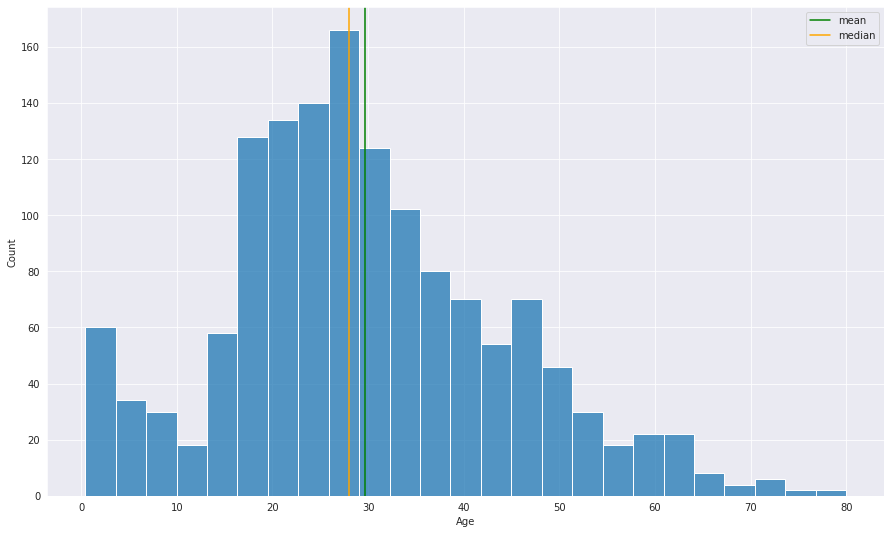

In [7]:
## Age
sns.set_style("darkgrid")
plt.figure(figsize = (15, 9))
sns.histplot(combined["Age"])
plt.axvline(x = combined["Age"].mean(), label = "mean", c = 'green')
plt.axvline(x = combined["Age"].median(), label = "median", c = 'orange')
plt.legend()
plt.show()

Both the median and mean age are close together at around 30 years old. Just because the age distribution is close to normal, I will impute the missing age values for mean. 

In [8]:
combined['Age'].fillna(combined['Age'].mean(), inplace = True)

In [9]:
## Cabin
combined['Cabin'].nunique()

147

[]

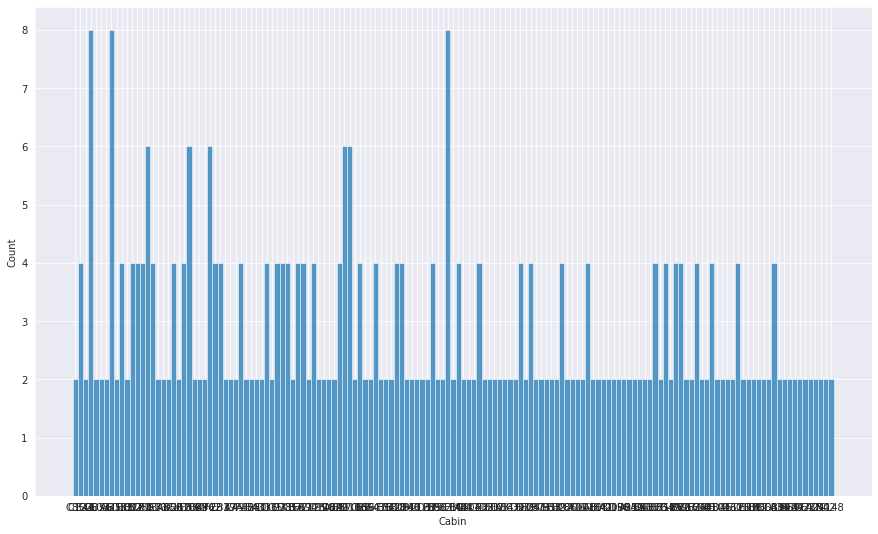

In [10]:
plt.figure(figsize = (15,9))
sns.histplot(combined['Cabin'])
plt.plot()

There is really not a perfect way to imputre missing cabin numbers given its unpredictable distribution. We will drop the column for now.

In [11]:
combined.drop(columns = "Cabin", inplace = True)
## dropping additional unnecessary columns
combined.drop(columns = ["Name", "Ticket", "PassengerId"], inplace = True)

In [12]:
## Embarked 
combined['Embarked'].nunique()

3

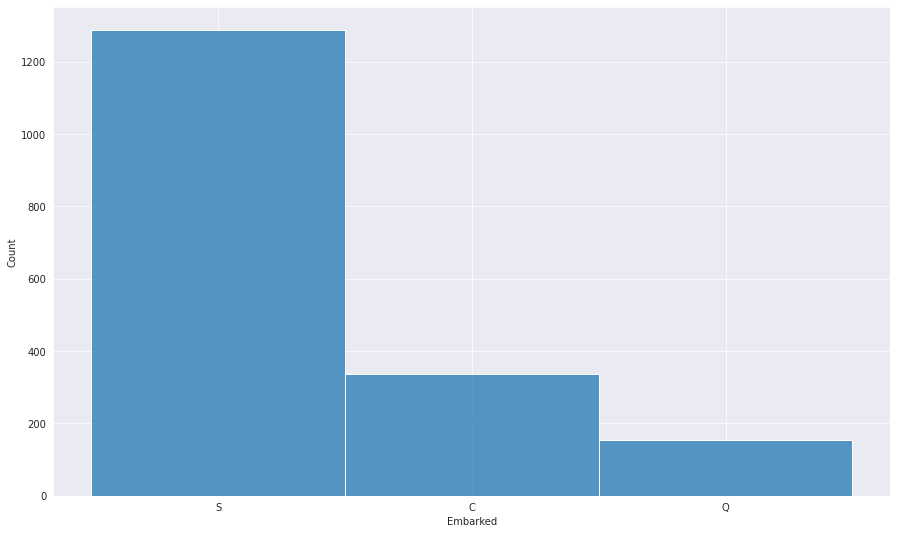

In [13]:
plt.figure(figsize = (15,9))
sns.histplot(combined['Embarked'])
plt.show()

The majority of passengers embarked from the Southampton port, I think it would be safe to assume that four missing passenger information is also Southamptom.

In [14]:
combined['Embarked'].fillna("S", inplace = True)

In [15]:
## Reavaluate missing values
combined.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

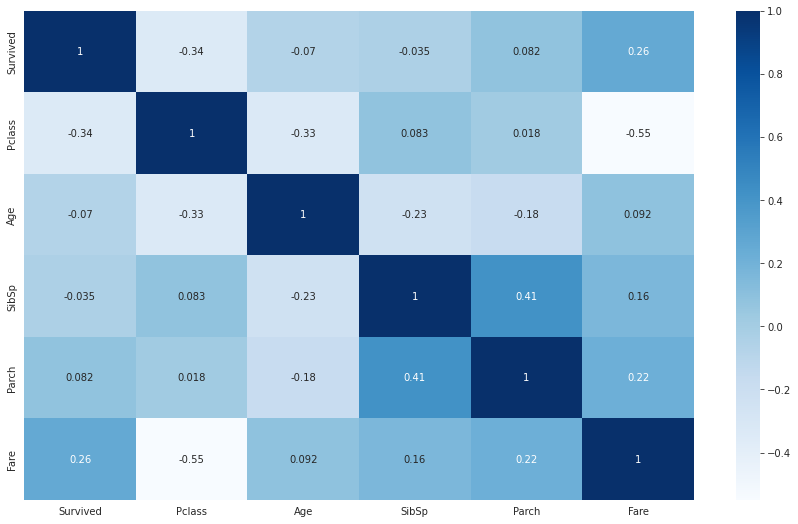

In [16]:
## generate a correlation matrix between features
plt.figure(figsize = (15,9))
sns.heatmap(combined.corr(), cmap = 'Blues', annot = True)
plt.show()

Whether a passenger survivied seems to have a slight **positive linear correlation** with the amount of *Fare* they paid and **negative linear correlation** with passenger class (*PClass*), but other than that, there is no strong linear correlation with other features. 

There seem to be some collinearity between **PClass and Fare** (passenger class and fare), **Parch and SibSp** (number of parents and siblings on the boat). We might consider merging these columns, if we decide fit a linear model. 

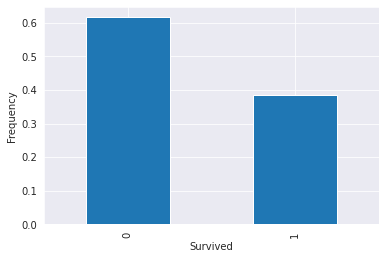

In [17]:
## investigating target feature and classes
combined['Survived'].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Survived")
plt.ylabel("Frequency")
plt.show()

## One Hot Encoding

In [18]:
categorical_cols = ["Sex", "Embarked"]
combined_encoded = pd.get_dummies(combined, columns = categorical_cols)
# drop columns manually since I do not want to drop the first class for Embarked
combined_encoded.drop(columns = ["Sex_female", "Embarked_Q"], inplace = True) # dropped Q for embarked since it is the least freqent class

In [19]:
combined_encoded.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,1,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## Split data set into train and test sets

In [27]:
X = combined_encoded.drop(columns = "Survived")
y = combined_encoded["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)
# stratify split by target feature since there is some class imbalance

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling using all features

I will use accuracy as a metric just to select the top 3 models to fine tune them for the best model

### Logistic Regression

In [28]:
logit = LogisticRegression()
kfolds = StratifiedKFold(n_splits = 5)  # use StratifiedKFold since we have class imbalance
logit_result = cross_val_score(logit, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
print(f"Model accuracy: {logit_result.mean()}")

Model accuracy: 0.7946602409638555


### Random Forest

In [29]:
rf = RandomForestClassifier(random_state = 111)
rf_result = cross_val_score(rf, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
print(f"Model accuracy: {rf_result.mean()}")

Model accuracy: 0.9005461847389558


### K-Nearest Neighbors

In [30]:
## use different k values to find an optimal value for the highest accuracy

k_range = range(3, 10, 2)
val_acc = dict()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_results = cross_val_score(knn, X_train_scaled, y_train, cv = 5, scoring = 'accuracy')
    val_acc[k] = knn_results.mean() 
val_acc


{3: 0.7995084337349398,
 5: 0.8179309236947792,
 7: 0.8083180722891565,
 9: 0.8091084337349399}

### XGBoost

In [48]:
xgboost_classifier = XGBClassifier()
xgboost_res = cross_val_score(xgboost_classifier, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
print(f"XGBoost accuracy: {xgboost_res.mean()}")

XGBoost accuracy: 0.8925397590361446


### SVM

In [42]:
svm_classifier = SVC()
svm_result = cross_val_score(svm_classifier, X_train_scaled, y_train, cv = kfolds, scoring = 'accuracy')
# print(f"SVM accuracy: {svm_result.mean()})
print(f"SVM accuracy: {svm_result.mean()}")

SVM accuracy: 0.8267309236947791


### Fine-tuning Random Forest, KNN, and XGBoost

In [60]:
estimators = [
    ("normalise", StandardScaler()), 
    ("model", XGBClassifier())]

pipe = Pipeline(estimators)

param_grid = [
    {"model": [XGBClassifier()],
    "normalise": [StandardScaler(), None],
    "model__gamma": [0.001, 0.01, 0.1, 1, 10],
    "model__reg_lambda":[0, 1, 10], 
    "model__max_depth": [3, 4, 5, 7],
    "model__colsample_bytree": [0.5], 
    "model__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    },
    
    {"model": [RandomForestClassifier()], 
     "normalise": [StandardScaler(), None],
     "model__n_estimators": [10, 30, 50, 100],
     "model__max_depth": [1, 2, 3, 4] 
    },
    
    {"model": [KNeighborsClassifier()],
     "normalise": [StandardScaler(), None],
     "model__n_neighbors": [3, 5, 7, 9, 11], 
     "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"]     
    }
]

grid = GridSearchCV(pipe, param_grid, cv=kfolds, n_jobs = -1)
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.fit(X_train, y_train)
print(f"Best score: {fittedgrid.best_score_} using {fittedgrid.best_params_}")

Best score: 0.8941526104417671 using {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.01,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=0, ...), 'model__colsample_bytree': 0.5, 'model__gamma': 0.01, 'model__learning_rate': 0.3, 'model__max_depth': 7, 'model__reg_lambda': 0, 'normalise': StandardScaler()}


In [64]:
# y_pred = fittedgrid.predict(X_test)
# submission = pd.read_csv('../input/titanic/gender_submission.csv')
